# Lab 5: Spam Detection

**Deadline**: Wednesday, November 6, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Justin Beland

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1-48NVtuU7t9ZIy_6Dn8xJZ6HMC86DTJU

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/Lab 5'

/content/drive/My Drive/Lab 5


In [4]:
# label for spam = 'spam'
# label for nonspam = 'ham'
foundspam = False
foundham = False
for line in open('SMSSpamCollection'):
  if not foundspam and line[0]=='s':
    print("spam: "+line[5:]+"\n")
    foundspam=True
  elif not foundham and line[0]=='h':
    print("not spam: "+line[4:]+"\n")
    foundham=True
  if foundham and foundspam:
    break

not spam: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


spam: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's




### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [5]:
scount = 0
hcount = 0
for line in open('SMSSpamCollection'):
  if line[0]=='s':
    scount+=1
  elif line[0]=='h':
    hcount+=1
  else:
    pass
print("spam: {}, not spam: {}".format(scount, hcount))

spam: 747, not spam: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [0]:
# advantage:
# can be used to interpret messages that contain more than one language
# can adapt to different grammarical styles

# disadvantage:
# longer processing time
# can generate more unusual/rarely used words

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [0]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                  tokenize=lambda x: x, # because are building a character-RNN
                  include_lengths=True, # to track the length of sequences, for batching
                  batch_first=True,
                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                  use_vocab=False,     # don't need to track vocabulary
                  is_target=True,      
                  batch_first=True,
                  preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                    "tsv",               # fields are separated by a tab
                    fields)
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2], stratified=True, strata_field='label')


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating non-spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [0]:
# having a balanced training set ensures that the training data is 
# representative of the actual data and is unbiased



# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [0]:
text_field.build_vocab(train)
#text_field.vocab.stoi # dict mapping of string to numerical identifier
#text_field.vocab.itos # list of strings indexed by numerical identifiers

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [0]:
# unk is unknown character
# pad is padding to fit to a defined string length

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [0]:
train_iter = torchtext.data.BucketIterator(train,
                      batch_size=32,
                      sort_key=lambda x: len(x.sms), # to minimize padding
                      sort_within_batch=True,        # sort within each batch
                      repeat=False)                  # repeat the iterator for many epochs

In [12]:
num_batches = 0
for batch in train_iter:
  # exit if we get to ten batches
  if num_batches == 10:
    break
  count = 0
  maxlength = 0
  for string in batch.sms[0]:
    if len(string)>maxlength:
      maxlength=len(string)
      print("max length update")
    for i in string:
      if i==1:
        count += 1

  print("number of pad: {}, max length: {}".format(count,maxlength))

  # reset variables
  count = 0
  maxlength = 0
  # add one to number of batches iterated
  num_batches+=1

max length update
number of pad: 30, max length: 122
max length update
number of pad: 22, max length: 43
max length update
number of pad: 6, max length: 41
max length update
number of pad: 48, max length: 69
max length update
number of pad: 24, max length: 28
max length update
number of pad: 25, max length: 160
max length update
number of pad: 23, max length: 53
max length update
number of pad: 12, max length: 26
max length update
number of pad: 0, max length: 155
max length update
number of pad: 27, max length: 158


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [13]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [0]:
class SpamDetect(nn.Module):
  def __init__(self, hidden_size, num_classes):
      super(SpamDetect, self).__init__()
      self.embed = torch.eye(len(text_field.vocab.stoi))
      self.hidden_size = hidden_size
      self.rnn = nn.RNN(len(text_field.vocab.stoi), hidden_size, batch_first=True)
      self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
      # Look up the embedding
      x = self.embed[x]
      # Set an initial hidden state
      h0 = torch.zeros(1, x.size(0), self.hidden_size)
      # Forward propagate the RNN
      out, _ = self.rnn(x, h0)
      # Pass the output of the last time step to the classifier
      out = self.fc(torch.max(out, dim=1)[0])
      return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify the 
You may use `torchtext.data.BucketIterator` to make your computation
faster.

In [0]:
def get_accuracy(model, data_iterator):
    """ Compute the accuracy of the `model` across a dataset `data`
    """
    correct = 0
    total = 0
    for text in data_iterator:
      output = model(text.sms[0])
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(text.label.view_as(pred)).sum().item()
      total += text.label.shape[0]
    return correct/total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [0]:
import matplotlib.pyplot as plt
import time

def train_RNN(model, batch_size=32, num_epochs=20, learning_rate = 0.0006,weight_decay=0.0002):
    start_time = time.time()
    torch.manual_seed(1000)
    train_iterator = torchtext.data.BucketIterator(train,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True,        # sort within each batch
                          repeat=False,
                          shuffle=True)                  

    valid_iterator = torchtext.data.BucketIterator(valid,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True,        # sort within each batch
                          repeat=False)                  # repeat the iterator for many epochs

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 
                lr=learning_rate,weight_decay = weight_decay)
    iter_num = []
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    n = 0
    
    for epoch in range(num_epochs):
        temp_loss = []
        for idx,batch in enumerate(train_iterator):
            out = model(batch.sms[0]) # forward pass
            loss = criterion(out, batch.label) # compute the total loss

            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            temp_loss.append(float(loss)/batch_size)             
        iter_num.append(n)
        train_losses.append(sum(temp_loss)/len(temp_loss)) 
        val_losses.append(get_val_loss(model,valid_iterator,batch_size))
        n += 1
        train_acc.append(get_accuracy(model,train_iterator)) # compute training accuracy 
        val_acc.append(get_accuracy(model,valid_iterator))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} |"+"Validation acc: {}").format(epoch + 1,train_acc[-1],val_acc[-1]))

    # plotting
    plt.title("Training Curve")
    plt.plot(iter_num, train_losses, label="Train")
    plt.plot(iter_num, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    plt.title("Training Curve")
    plt.plot(iter_num, train_acc, label="Train")
    plt.plot(iter_num, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    end = time.time()
    time_elapsed = end - start_time
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Trained Duration: {} seconds".format(time_elapsed))

In [0]:
def get_val_loss(model,data_loader,batch_size):
  losses = []
  criterion = nn.CrossEntropyLoss()
  for idx,batch in enumerate(data_loader):
      out = model(batch.sms[0])             # forward pass
      loss = criterion(out, batch.label) # compute the total loss
      losses.append(float(loss)/batch_size)
  return sum(losses)/len(losses)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyper parameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1: Train acc: 0.9020063007793069 |Validation acc: 0.8376681614349776
Epoch 2: Train acc: 0.9479356657270768 |Validation acc: 0.9668161434977578
Epoch 3: Train acc: 0.9305256176421821 |Validation acc: 0.9739910313901345
Epoch 4: Train acc: 0.9547338749792738 |Validation acc: 0.9614349775784753
Epoch 5: Train acc: 0.9560603548333609 |Validation acc: 0.9730941704035875
Epoch 6: Train acc: 0.9602056043773836 |Validation acc: 0.9695067264573991
Epoch 7: Train acc: 0.9635218040126016 |Validation acc: 0.9659192825112107
Epoch 8: Train acc: 0.9653457138119714 |Validation acc: 0.9704035874439462
Epoch 9: Train acc: 0.9668380036478196 |Validation acc: 0.9748878923766816
Epoch 10: Train acc: 0.9679986735201459 |Validation acc: 0.9748878923766816
Epoch 11: Train acc: 0.9686619134471895 |Validation acc: 0.9730941704035875
Epoch 12: Train acc: 0.9684961034654286 |Validation acc: 0.9721973094170404
Epoch 13: Train acc: 0.9754601226993865 |Validation acc: 0.9730941704035875
Epoch 14: Train acc: 

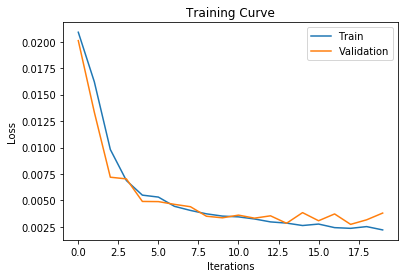

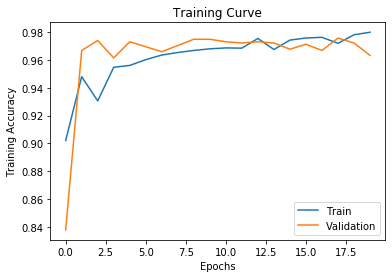

Final Training Accuracy: 0.9799369922069309
Final Validation Accuracy: 0.9632286995515695
Trained Duration: 92.74012851715088 seconds


In [32]:
model = SpamDetect(10, 2)
train_RNN(model)

# trying with a small hidden size (3) led to decreased accuracy, 
# possibly due to the loss of sequential information

# 
#


Epoch 1: Train acc: 0.8996849610346543 |Validation acc: 0.873542600896861
Epoch 2: Train acc: 0.934007627259161 |Validation acc: 0.9650224215246637
Epoch 3: Train acc: 0.9573868346874482 |Validation acc: 0.9506726457399103
Epoch 4: Train acc: 0.9588791245232963 |Validation acc: 0.9452914798206278
Epoch 5: Train acc: 0.9522467252528602 |Validation acc: 0.9668161434977578
Epoch 6: Train acc: 0.9577184546509699 |Validation acc: 0.9632286995515695
Epoch 7: Train acc: 0.9699883933012767 |Validation acc: 0.9632286995515695
Epoch 8: Train acc: 0.9683302934836677 |Validation acc: 0.9506726457399103
Epoch 9: Train acc: 0.9749626927541037 |Validation acc: 0.9587443946188341
Epoch 10: Train acc: 0.9757917426629084 |Validation acc: 0.9623318385650225
Epoch 11: Train acc: 0.9761233626264301 |Validation acc: 0.9641255605381166
Epoch 12: Train acc: 0.9789421323163654 |Validation acc: 0.9641255605381166
Epoch 13: Train acc: 0.9806002321339745 |Validation acc: 0.9632286995515695
Epoch 14: Train acc: 0.

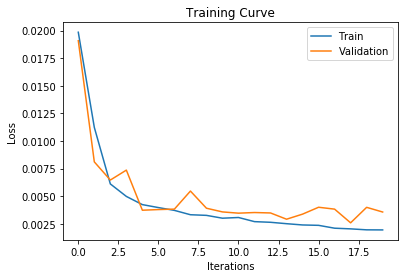

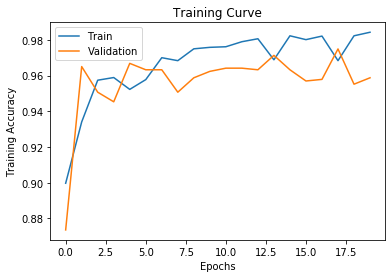

Final Training Accuracy: 0.9842480517327143
Final Validation Accuracy: 0.9587443946188341
Trained Duration: 97.64005637168884 seconds


In [35]:
model2 = SpamDetect(20, 2)
train_RNN(model2)

# increasing the number of hidden units should allow the neural to 
# code more information related to the sequence of characters
# however it did not improve the validation accuracy

Epoch 1: Train acc: 0.9381528768031836 |Validation acc: 0.9713004484304932
Epoch 2: Train acc: 0.9537390150887083 |Validation acc: 0.9730941704035875
Epoch 3: Train acc: 0.9593765544685791 |Validation acc: 0.9695067264573991
Epoch 4: Train acc: 0.9643508539214061 |Validation acc: 0.9668161434977578
Epoch 5: Train acc: 0.9653457138119714 |Validation acc: 0.9757847533632287
Epoch 6: Train acc: 0.9676670535566241 |Validation acc: 0.9739910313901345
Epoch 7: Train acc: 0.9691593433924722 |Validation acc: 0.9721973094170404
Epoch 8: Train acc: 0.9689935334107114 |Validation acc: 0.9757847533632287
Epoch 9: Train acc: 0.9757917426629084 |Validation acc: 0.9730941704035875
Epoch 10: Train acc: 0.9779472724258 |Validation acc: 0.9704035874439462
Epoch 11: Train acc: 0.9781130824075609 |Validation acc: 0.9757847533632287
Epoch 12: Train acc: 0.9691593433924722 |Validation acc: 0.9721973094170404
Epoch 13: Train acc: 0.981263472061018 |Validation acc: 0.9659192825112107
Epoch 14: Train acc: 0.97

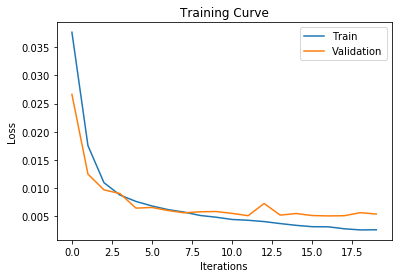

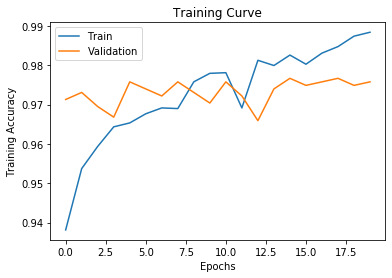

Final Training Accuracy: 0.9883933012767369
Final Validation Accuracy: 0.9757847533632287
Trained Duration: 158.5804796218872 seconds


In [42]:
model3 = SpamDetect(10, 2)
train_RNN(model3, batch_size=16)
# decreasing the batch size would allow it to use less padding
# and improve results (since we would get tensors with fewer pad 
# tokens and more actual information).

Epoch 1: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 2: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 3: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 4: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 5: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 6: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 7: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 8: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 9: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 10: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 11: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 12: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 13: Train acc: 0.4800198971978113 |Validation acc: 0.8654708520179372
Epoch 14: Train acc: 

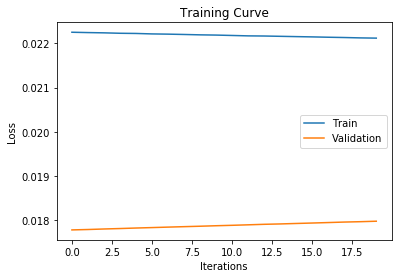

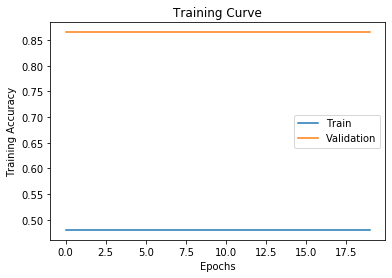

Final Training Accuracy: 0.4800198971978113
Final Validation Accuracy: 0.8654708520179372
Trained Duration: 93.05963826179504 seconds


In [45]:
model4 = SpamDetect(10, 2)
train_RNN(model4, learning_rate=1e-6)
# decreasing the learning rate should improve the accuracy of the network
# since we are less likely to skip over the global minimum
# the learning rate however proved to be too small and it seems that the
# model is trapped inside a local minimum.

In [0]:
# Best model:
# model 3, highest validation accuracy 97.5%

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [0]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [0]:
# False positive - will flag non spam message as spam and the user 
# could miss out on important messages
# False negative - will not flag spam message and allow the user to
# see the spam

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [22]:
test_iterator = torchtext.data.BucketIterator(test,
                        batch_size=32,
                        sort_key=lambda x: len(x.sms), # to minimize padding
                        sort_within_batch=True,     # sort within each batch
                        repeat=False,
                        shuffle=True)
get_accuracy(model3, test_iterator)

0.9703770197486535

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [23]:
spam_iterator = torchtext.data.BucketIterator(valid_spam,
                        batch_size=32,
                        sort_key=lambda x: len(x.sms), # to minimize padding
                        sort_within_batch=True,     # sort within each batch
                        repeat=False,
                        shuffle=True)
ham_iterator = torchtext.data.BucketIterator(valid_nospam,
                        batch_size=32,
                        sort_key=lambda x: len(x.sms), # to minimize padding
                        sort_within_batch=True,     # sort within each batch
                        repeat=False,
                        shuffle=True)
fn = 1-get_accuracy(model3, spam_iterator) # 1-accuracy rate
fp = 1-get_accuracy(model3, ham_iterator) # 1-accuracy rate

print("False positive rate: {} \n False negative rate: {}".format(fp, fn))

False positive rate: 0.025906735751295318 
 False negative rate: 0.07333333333333336


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [30]:
msg = "machine learning is sooo cool!"

encoded = torch.zeros(len(msg))
for index in range(len(msg)):
  encoded[index] = text_field.vocab.stoi[msg[i]]
encoded = encoded.type(torch.LongTensor).unsqueeze(dim=0)
prediction = model3(encoded)



tensor([[ 1.2807, -1.8424]], grad_fn=<AddmmBackward>)

In [40]:
probability = torch.nn.functional.softmax(prediction)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [44]:
probability[0][0]
# it predicts with a 95.78% accuracy that the message is spam

tensor(0.9578, grad_fn=<SelectBackward>)

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [0]:
# Detecting spam is a difficult task, mainly due to the variations
# in how we use language to express ideas.
# In addition, we must take into account the metric for whether to
# call a message spam or not (e.g. ads sent over email may be
# useful to some users who happen to need the product but not most
# users).

# This model could act as a baseline model since it is a rather
# simple model that uses one-hot encodings on characters. It could be
# converted into a more complex model through the use of more
# sophisticated embeddings such as the Glove embeddings discussed in
# class. Glove embeddings encode more information about each word
# than the one hot encodings used here and could produce better results
# on real-world data.